In [1]:
%matplotlib notebook

import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt


from synthetic_data import load_data_by_gtype
from ic import make_partial_cascade, simulated_infection_time_3d
from graph_generator import add_p_and_delta
from plot_utils import plot_snapshot
from utils import infeciton_time2weight
from ic import source_likelihood_drs


In [2]:
g = load_data_by_gtype('balanced-tree', '2-6')[0]

<IPython.core.display.Javascript object>


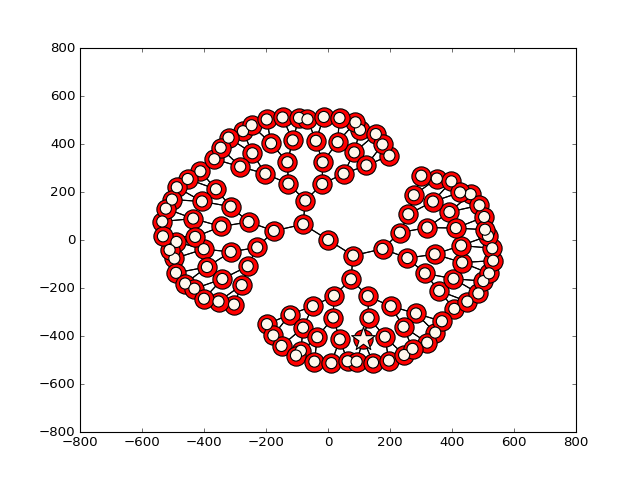

In [3]:
pos = graphviz_layout(g)
nx.draw_networkx(g, pos=pos, with_labels=False)

In [95]:
N2 = 5000
g = add_p_and_delta(g, 0.2, 1)
inf_time_3d = simulated_infection_time_3d(g, N2)

100%|██████████| 5000/5000 [00:06<00:00, 716.28it/s]


In [5]:
source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.4)
print(np.sum(np.invert(np.isinf(list(infection_times.values())))))
plot_snapshot(g, pos, infeciton_time2weight(infection_times), queried_nodes=obs_nodes, source_node=source)

1


<IPython.core.display.Javascript object>


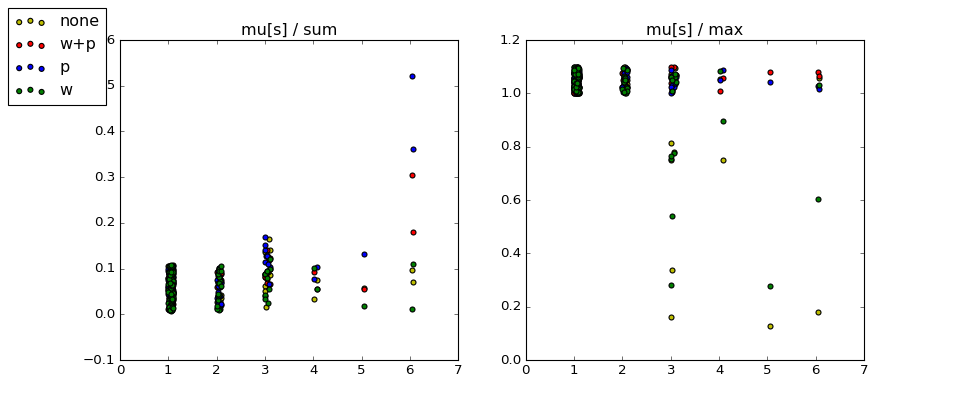

/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


In [124]:
import collections
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cascade_size = []
sum_ratio = collections.defaultdict(list)
max_ratio = collections.defaultdict(list)
for i in range(100):
    source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.4)
    infn = np.sum(np.invert(np.isinf(list(infection_times.values()))))
    cascade_size.append(infn)
    for use_weight, use_preconditioning in itertools.product([False, True], [False, True]):    
        sll = source_likelihood_drs(source, g.number_of_nodes(), obs_nodes, inf_time_3d, infection_times, N2,
                                       use_time_weight=use_weight, use_preconditioning=use_preconditioning)
        
        name = []
        if use_weight:
            name.append('w')
        
        if use_preconditioning:
            name.append('p')
        name = '+'.join(name)
        if name == '':
            name = 'none'
            
        sum_ratio[name].append(sll[source] / sll.sum())
        max_ratio[name].append(sll[source] / sll.max())

lines = []
color_map = {v: c for v, c in zip(['w+p', 'w', 'p', 'none'], ['r', 'g', 'b', 'y'])}
cascade_size = np.array(cascade_size) + 0.1 * np.random.random(len(cascade_size))
for k, ratio in sum_ratio.items():
    l = ax[0].scatter(cascade_size, np.array(ratio) + 0.1 * np.random.random(len(cascade_size)),
                  c=color_map[k])
    lines.append(l)
# ax[0].legend(list(sum_ratio.keys()), loc='upper left')
ax[0].set_title('mu[s] / sum')

for k, ratio in max_ratio.items():
    ax[1].scatter(cascade_size, np.array(ratio) + 0.1 * np.random.random(len(cascade_size)),
                 c=color_map[k])
# ax[1].legend(list(sum_ratio.keys()), loc='bottom left')
ax[1].set_title('mu[s] / max')    

fig.legend(lines, list(sum_ratio.keys()), loc='upper left')

In [125]:
import pandas as pd
df = pd.DataFrame.from_dict(sum_ratio)
df.describe()

,none,p,w,w+p
count,100.000000,100.000000,100.000000,100.000000
mean,0.011889,0.023476,0.009941,0.016395
std,0.014585,0.058942,0.007602,0.031271
min,0.005771,0.007874,0.005949,0.007874
25%,0.007874,0.007874,0.007874,0.007874
50%,0.007874,0.007874,0.007874,0.007874
75%,0.007874,0.007874,0.007874,0.007874
max,0.065750,0.456291,0.037979,0.257946


- **!!**: without time weight, the modeling is better

for kr-rand graph, strange pattern:

- larger cascade size gives bad result
- small cascade size also gives bad result

In [117]:
if True:
    def source_likelihood_drs(source, n_nodes, obs_nodes, inf_time_3d,
                              infection_times,
                              N2,
                              use_time_weight=True,
                              use_preconditioning=True,
                              eps=1e-1):
        times = np.array([infection_times[o] for o in obs_nodes])
        t_max, t_min = times.max(), times.min()
        
        if use_time_weight:
            def weight_func(t):
                if t_max == t_min:
                    return 0
                else:
                    return (t - t_min) / (t_max - t_min)
        
        source_likelihood = np.ones(n_nodes, dtype=np.float64) / n_nodes
        obs_nodes = list(obs_nodes)
        for o1, o2 in itertools.combinations(obs_nodes, 2):
            t1, t2 = infection_times[o1], infection_times[o2]
            if use_preconditioning:
                sim_mask = np.invert(
                    np.logical_or(
                        inf_time_3d[:, o1, :]==-1,
                        inf_time_3d[:, o2, :]==-1))
                counts = np.sum(sim_mask, axis=1)

                probas = (np.sum(((inf_time_3d[:, o1, :] - inf_time_3d[:, o2, :]) == (t1 - t2)) * sim_mask,
                                   axis=1)
                          / counts)
                probas[np.isnan(probas)] = 0
            else:
                probas = (np.sum(
                    (inf_time_3d[:, o1, :] - inf_time_3d[:, o2, :]) == (t2 - t1), axis=1)
                          / N2)
            if False:
                print('t1={}, t2={}'.format(t1, t2))
                print('source proba: {:.2f}'.format(probas[source]+eps))
                print('obs probas: {}'.format([probas[obs]+eps for obs in set(obs_nodes)-{source}]))

            if use_time_weight:
                weight = weight_func(min(t1, t2))            
                source_likelihood *= ((probas + weight) / 2 + eps)
            else:
                source_likelihood *= (probas + eps)
            source_likelihood /= source_likelihood.sum()
        return source_likelihood
else:
    def source_likelihood_drs(n_nodes, obs_nodes, inf_time_3d,
                              infection_times,
                              N2,
                              eps=1e-5):
        source_likelihood = np.ones(n_nodes, dtype=np.float64) / n_nodes
        obs_nodes = list(obs_nodes)
        for o1, o2 in itertools.combinations(obs_nodes, 2):
            t1, t2 = infection_times[o1], infection_times[o2]
            sim_mask = np.invert(
                np.logical_or(
                    inf_time_3d[:, o1, :]==-1,
                    inf_time_3d[:, o2, :]==-1))
            counts = np.sum(sim_mask, axis=1)

            probas = (np.sum(((inf_time_3d[:, o1, :] - inf_time_3d[:, o2, :]) == (t1 - t2)) * sim_mask,
                               axis=1)
                      / counts)
            probas[np.isnan(probas)] = 0
            source_likelihood *= (probas + eps)
            source_likelihood /= source_likelihood.sum()
        return source_likelihood

<IPython.core.display.Javascript object>


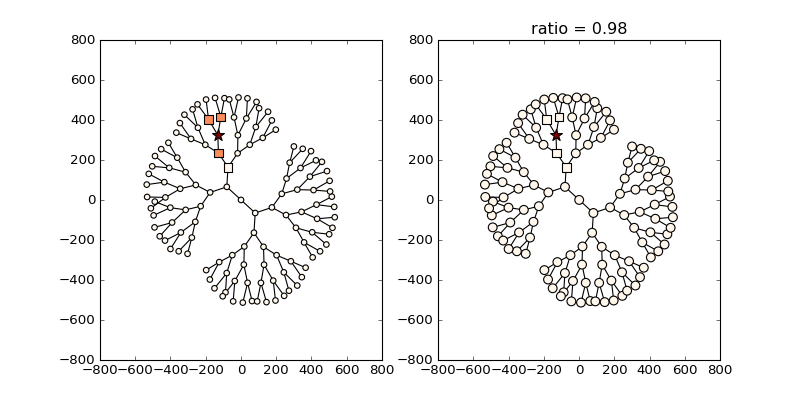

t1=1, t2=1
source proba: 1.10
obs probas: [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 1.1000000000000001]
t1=1, t2=0
source proba: 1.10
obs probas: [0.10000000000000001, 1.1000000000000001, 0.10000000000000001, 1.1000000000000001]
t1=1, t2=2
source proba: 1.10
obs probas: [1.1000000000000001, 1.1000000000000001, 0.10000000000000001, 1.1000000000000001]
t1=1, t2=1
source proba: 1.10
obs probas: [0.10000000000000001, 1.1000000000000001, 0.10000000000000001, 0.10000000000000001]
t1=1, t2=0
source proba: 1.10
obs probas: [1.1000000000000001, 0.10000000000000001, 1.1000000000000001, 1.1000000000000001]
t1=1, t2=2
source proba: 1.10
obs probas: [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
t1=1, t2=1
source proba: 1.10
obs probas: [1.1000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
t1=0, t2=2
source proba: 1.10
obs probas: [0.10000000000000001, 1.1000000000000001, 0.10000000000000001, 1.100000000000000

/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in true_divide


In [91]:
infn = 0
while infn < 5:
    source, obs_nodes, infection_times, tree = make_partial_cascade(g, 1.0)
    infn = np.sum(np.invert(np.isinf(list(infection_times.values()))))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_snapshot(g, pos, infeciton_time2weight(infection_times), ax=ax[0],
              queried_nodes=obs_nodes, source_node=source, 
              max_node_size=250)
sll = source_likelihood_drs(
    source,
    g.number_of_nodes(), obs_nodes, inf_time_3d, infection_times, 500)
weight = {i: v for i, v in enumerate(sll.tolist())}
plot_snapshot(g, pos, weight, ax=ax[1],
              queried_nodes=obs_nodes, source_node=source, max_node_size=250)
ax[1].set_title('ratio = {:.2f}'.format(sll[source] / np.sum(sll)))

In [9]:
[(o, sll[o]) for o in obs_nodes], source

([(32, nan), (7, nan), (31, nan), (63, nan), (15, nan)], 32)

<IPython.core.display.Javascript object>


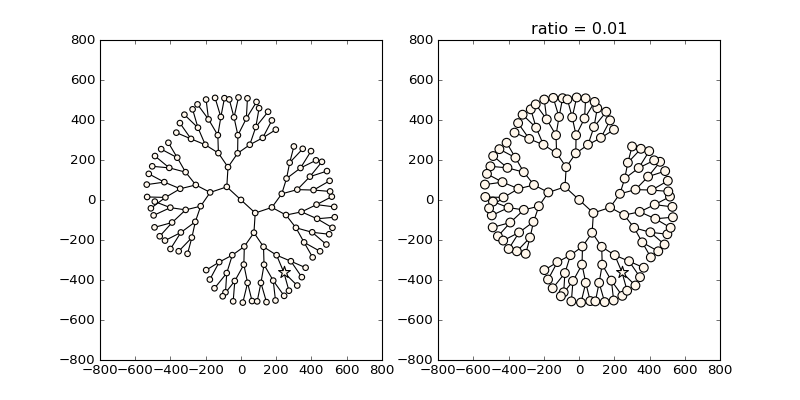

In [10]:
infn = 0
while infn != 1:
    source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.4)
    infn = np.sum(np.invert(np.isinf(list(infection_times.values()))))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_snapshot(g, pos, infeciton_time2weight(infection_times), ax=ax[0],
              queried_nodes=obs_nodes, source_node=source,
              max_node_size=250)
sll = source_likelihood_drs(g.number_of_nodes(), obs_nodes, inf_time_3d, infection_times, 500)
weight = {i: v for i, v in enumerate(sll.tolist())}
plot_snapshot(g, pos, weight, ax=ax[1],
              queried_nodes=obs_nodes, source_node=source, max_node_size=250)
ax[1].set_title('ratio = {:.2f}'.format(sll[source] / np.sum(sll)))

- plot of `mu[source] / mu.max()` is different from `mu[source] / mu.sum()`
- when source is the only infection, estimation does not run
  - estimation does not use **uninfected** node, which could be used however
  - could define the `fraction` parameter to be the fraction of **all** nodes that are observed
- if observing uninfected nodes, the model should change


Questions:

- whether conditioning on the pair is both infected is useful?
- whether more weight on earlier infection is useful?
- whether using uninfected nodes is useful?